## Get the match between fourier spectra and filtering spectra for idealized fields.

In [12]:
import numpy as np
import matplotlib.pyplot as plt


### Generate field 

$$
f(x) = \sum_{-\infty}^{\infty} \hat{f}(k) e^{ikx} dk
$$

where $e^{ikx}  = cos(kx) + i sin(kx)$. Since $f(x)$ is real, $\hat{f}(k) = \hat{f}(-k)$. 

So we can use cosines only: 
$$
f(x) = 2 \sum_{0}^{\infty} \hat{f}(k) \cos{(kx)}
$$


In [1131]:
# Make grids
L = np.pi
dx = L/501 #helps break into perfect grids, otherwise last point might have a small offset from periodic.

x = np.arange(-L, L, dx)
x.shape

(1002,)

In [1132]:
k_small = 2*np.pi/(2*L)
k_large = 2*np.pi/(2*dx) # Nyquist Frequency
print(k_small, k_large)

1.0 501.0


In [1133]:
dk = k_small
k = np.arange(k_small, k_large, dk)
k.shape

(500,)

Fourier spectrum of f(x)
$$
E(k) = \sum_{k-1/2 <|k|<k+1/2}\frac{1}{2} |\hat{f}(k)|^2, k=0,1,2, ...
$$

In [1134]:
# Make power law

k_break = k_small*5 # where slope break is
fhat = np.zeros_like(k)

alpha = 2 # power law slope

C = 1/ (k_break**(-alpha/2)) # matching coeff.

fhat[k<=k_break] = 1.
fhat[k>k_break] = C*k[k>k_break]**(-alpha/2) # Note that the energy spectrum is square of fhat

k_break2 = k_large/4
fhat[k>k_break2] = 0.
#fhat[k>=k_large/2] = 0.

Ek = fhat**2

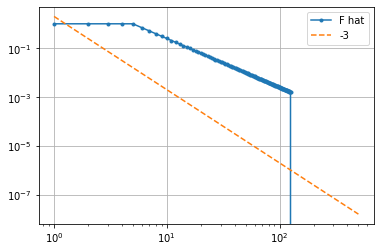

In [1135]:
plt.plot(k , Ek,'.-', label='F hat')

plt.plot(k, 2*k**(-3), '--', label='-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [1136]:
k_grid, x_grid = np.meshgrid(k, x)

In [1137]:
# Make signal
# Random phase 
phi = 2*np.pi*np.random.randn(len(k))


phi_grid, x_grid2 = np.meshgrid(phi, x)
phi_grid.shape

(1002, 500)

In [1138]:
fsignal = np.sum(2*fhat*np.cos(k_grid*x_grid + phi_grid), axis=1)

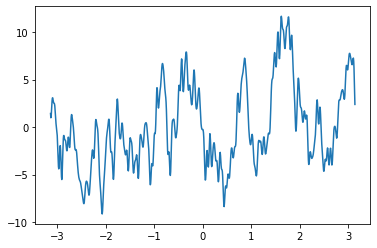

In [1139]:
plt.plot(x, fsignal)

Plancherel's relation 

$$
1/2<|f(x)|^2> = \sum_{0}^{\infty}E(k)
$$

In [1140]:
total_var = np.mean(0.5*fsignal**2)
sum_Ek = np.sum(Ek)
print('Total variance:', total_var , '. Sum of spectrum: ', sum_Ek, 'Diff:' , total_var-sum_Ek)

Total variance: 9.333871760121806 . Sum of spectrum:  9.333871760121855 Diff: -4.973799150320701e-14


### Fourier spectrum

Following: https://docs.scipy.org/doc/scipy/tutorial/fft.html#d-discrete-fourier-transforms 

In [1141]:
from scipy.fft import fft, ifft

In [1142]:
N = len(fsignal)

In [1143]:
fsignal_hat = fft(fsignal)

In [1144]:
fsignal_hat_spec = np.abs(fsignal_hat[1:int(N/2-1)]/(N))**2 # divide by N to to have the format that we chose in previous section
np.sum(fsignal_hat_spec)

9.333871760121804

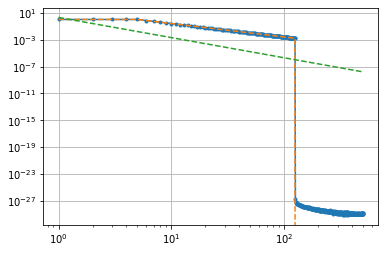

In [1145]:
plt.plot(k[:-1], fsignal_hat_spec, '.-') # there is one wavenumber missing 
plt.plot(k, Ek, '--')

plt.plot(k, 2*k**(-3), '--', label='-3')
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [1146]:
fsignal_inv = ifft(fsignal_hat)

/home/dbalwada/.conda/envs/pangeo/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


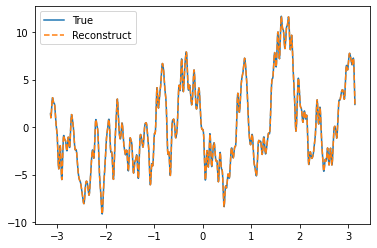

In [1147]:
plt.plot(x, fsignal, label='True')
plt.plot(x, fsignal_inv, '--', label='Reconstruct')

plt.legend()


In [1148]:
## HW : How will you remove the random phases, or or estimate the phases from the coeff? 

### Can we use xrft? 

### Filtering vs fourier spectrum
Get the match between fourier spectra and filtering spectra for idealized fields.
- u_l(x)
- Cumulative spectrum: $\epsilon(k_l) = 1/2<|u_l(x)|^2>$, where $k_l=1/l$. 
- Filtering spectrum: $\overline{E}(k_l) = \frac{d}{d k_l} \epsilon(k_l) $

In [1149]:
from scipy.ndimage import gaussian_filter1d

In [1150]:
u = fsignal

In [1151]:
# l = sig/4/np.sqrt(12) 

#l = np.arange(1, int(N/4)) * dx
#k_l = 1/l

#k_l = np.logspace(0, 3, 200) #k
#l = 1/k_l
l = dx*np.arange(1, N/4)
#k_l = 2*np.pi/l
k_l = 1/l

u_l = np.zeros((N, len(l))) # x, filter_scale as dim

for i in range(len(l)):
    u_l[:, i] = gaussian_filter1d(u, l[i] /dx, mode='wrap')
    

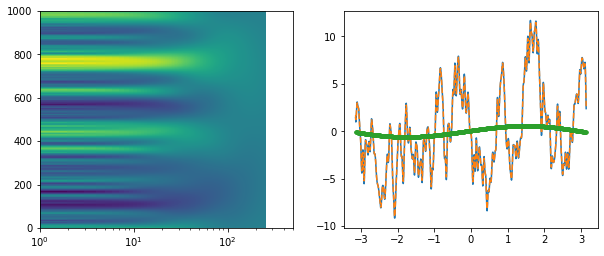

In [1155]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(u_l)
plt.xscale('log')
plt.xlim([1, 500])

plt.subplot(122)
plt.plot(x, u)
plt.plot(x, u_l[:,0], '--')
plt.plot(x, u_l[:,-1], '.-')

In [1156]:
cum_spec = 0.5 * np.mean(u_l**2, axis=0)

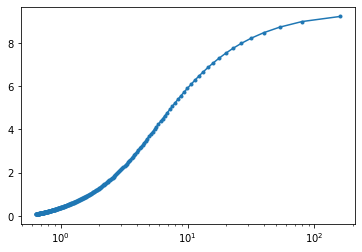

In [1157]:
plt.plot(k_l, cum_spec, '.-')
plt.xscale('log')
#plt.xscale('log')

In [1158]:
filt_spec = (cum_spec[1:] - cum_spec[:-1])/ (k_l[1:] - k_l[:-1])

In [1159]:
k_mid = (k_l[1:] + k_l[:-1])/2

(1e-05, 1.5)

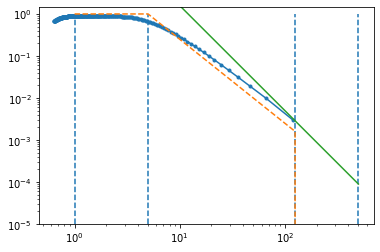

In [1160]:
plt.plot(k_mid, filt_spec, '.-')

plt.plot(k, Ek, '--')

plt.plot(k, 500*k**-2.5)

plt.vlines([k_break, k_small, k_large, 2*np.pi/8/dx], 1e-5, 1, linestyle='--')


plt.xscale('log')
plt.yscale('log')

#plt.ylim([min(Ek)*0.5, max(Ek)*1.5])
plt.ylim([1e-5, max(Ek)*1.5])


(1, 100)

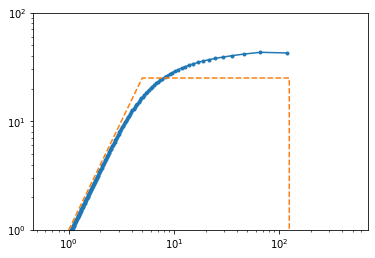

In [1161]:
plt.plot(k_mid, filt_spec / (k_mid**-2), '.-')

plt.plot(k, Ek/(k**-2.), '--')

#plt.plot(k, 500*k**-2.5)

#plt.vlines([k_break, k_small, k_large, 2*np.pi/8/dx], 1e-5, 1, linestyle='--')

plt.xscale('log')
plt.yscale('log')

plt.ylim([1, 100])


(0.001, 10000.0)

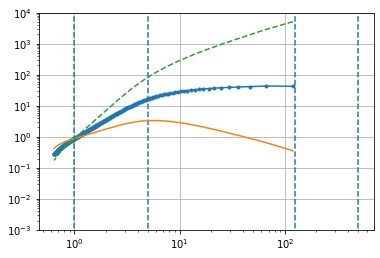

In [1162]:
# compensated plots 
plt.plot(k_mid, filt_spec / (k_mid**-2), '.-')
plt.plot(k_mid, filt_spec / (k_mid**-1), '-')
plt.plot(k_mid, filt_spec / (k_mid**-3), '--')


#plt.plot(k, 500*k**-2.5)

plt.vlines([k_break, k_small, k_large, 2*np.pi/8/dx], 1e-5, 1e5, linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.ylim([1e-3, 1e4])

- The filtering spectrum is able to reproduce the fourier spectrum qualitatively and capture a similar slope. 
- The sharp slope break is not easily determined. 
- At the smallest scales, near the grid scale, there is a bump in energy, likely due to jaggedness of discreteness. We can remove this to some degree by filling in extra points in between the grid, so there are less sharp changes in values.  

Try filter kernels that allow us to work with slopes steeper than -3, as we expect that to be the case.

In [1163]:
# Filtered spectra
# Cumulative vs 

In [1164]:
from scipy.ndimage.filters import convolve1d
import numpy

In [1165]:
def our_gaussian_kernel1d(sigma, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    
    # p(x) = 0 + 0*x - 1/2/sigma^2 x^2 # form of the exponent in a gaussian
    p = numpy.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    
    # define the range over which we need the values, +1  because of weird functionality of arange
    x = numpy.arange(-radius, radius + 1)
    
    # E^(p(x))
    phi_x = numpy.exp(p(x), dtype=numpy.double)
    
    # normalization
    phi_x /= phi_x.sum()
    
    
    return phi_x

In [1166]:
def top_hat(sigma, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    
    # p(x) = 0 + 0*x - 1/2/sigma^2 x^2 # form of the exponent in a gaussian
    #p = numpy.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    
    # define the range over which we need the values, +1  because of weird functionality of arange
    x = numpy.arange(-radius, radius + 1)
    
    # E^(p(x))
    #phi_x = numpy.exp(p(x), dtype=numpy.double)
    
    phi_x = 0.*x

    phi_x[abs(x)<=sigma/2] = 1./sigma
    
    # normalization
    phi_x /= phi_x.sum()
    
    
    return phi_x

In [1167]:
def graded_top_hat(sigma, radius):
    """
    Computes a 1D Gaussian convolution kernel.
    """
    
    # p(x) = 0 + 0*x - 1/2/sigma^2 x^2 # form of the exponent in a gaussian
    #p = numpy.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    
    # define the range over which we need the values, +1  because of weird functionality of arange
    x = numpy.arange(-radius, radius + 1)
    
    # E^(p(x))
    #phi_x = numpy.exp(p(x), dtype=numpy.double)
    
    phi_x = 1 - np.tanh(10*(2*np.abs(x)/sigma - 1))

    
    # normalization
    phi_x /= phi_x.sum()
    
    
    return phi_x

In [1186]:
ker_gauss = our_gaussian_kernel1d(1, 10)
ker_top = top_hat(np.sqrt(12)*1,10)
ker_grad_top = graded_top_hat(np.sqrt(12)*1,10)

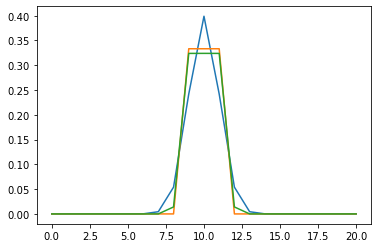

In [1187]:
plt.plot(ker_gauss)
plt.plot(ker_top)
plt.plot(ker_grad_top)

In [1170]:
def my_gaussian_filter1d(f, sigma, mode='wrap', truncate=4.0):
    """ wrapper function for convolve"""
    lw = int(truncate * float(sigma) + 0.5)
    
    weights = our_gaussian_kernel1d(sigma, lw)
    
    return convolve1d(f, weights, mode = mode)
     

In [1171]:
def my_filter1d(f, sigma, kernel, mode='wrap', truncate=4.0):
    """ wrapper function for convolve"""
    lw = int(truncate * float(sigma) + 0.5)
    
    weights = kernel(sigma, lw)
    
    return convolve1d(f, weights, mode = mode)
     

In [1209]:
l/dx

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [1216]:

u_l_myfilt = np.zeros((N, len(l))) # x, filter_scale as dim

u_l_tophat = np.zeros((N, len(l)))
u_l_gradtophat = np.zeros((N, len(l)))


for i in range(len(l)):
    u_l_myfilt[:, i] = my_gaussian_filter1d(u, l[i] /dx, mode='wrap')
    
    u_l_tophat[:, i] = my_filter1d(u, l[i]*np.sqrt(12.) /dx, top_hat, mode='wrap')
    
    u_l_gradtophat[:, i] = my_filter1d(u, l[i]*np.sqrt(12.) /dx, graded_top_hat, mode='wrap')

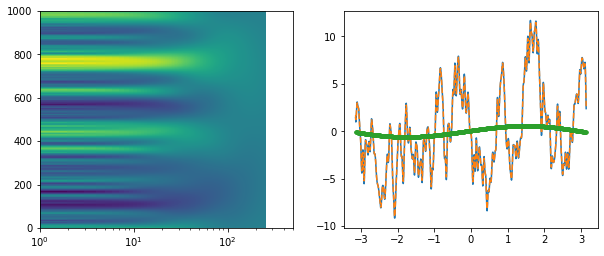

In [1217]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(u_l_myfilt)
plt.xscale('log')
plt.xlim([1, 500])

plt.subplot(122)
plt.plot(x, u)
plt.plot(x, u_l_myfilt[:,0], '--')
plt.plot(x, u_l_myfilt[:,-1], '.-')

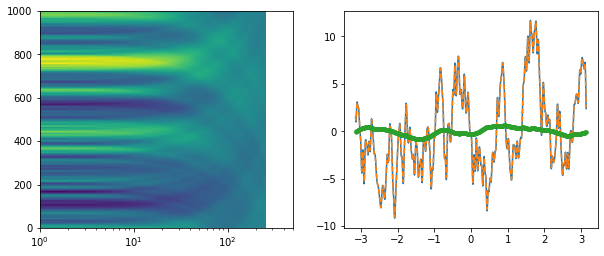

In [1218]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(u_l_tophat)
plt.xscale('log')
plt.xlim([1, 500])

plt.subplot(122)
plt.plot(x, u)
plt.plot(x, u_l_tophat[:,0], '--')
plt.plot(x, u_l_tophat[:,-1], '.-')

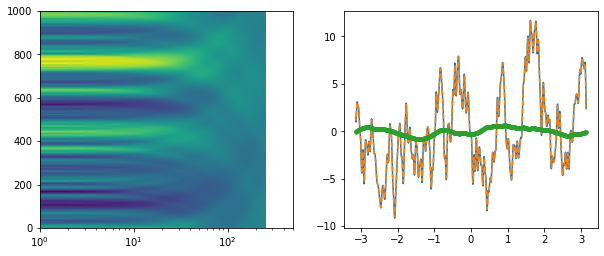

In [1219]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.pcolormesh(u_l_gradtophat)
plt.xscale('log')
plt.xlim([1, 500])

plt.subplot(122)
plt.plot(x, u)
plt.plot(x, u_l_tophat[:,0], '--')
plt.plot(x, u_l_tophat[:,-1], '.-')

In [1220]:
cum_spec_myfilt = 0.5 * np.mean(u_l_myfilt**2, axis=0)
cum_spec_tophat = 0.5 * np.mean(u_l_tophat**2, axis=0)
cum_spec_gradtophat = 0.5 * np.mean(u_l_gradtophat**2, axis=0)

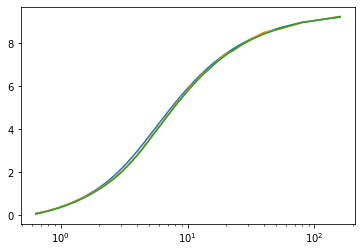

In [1221]:
plt.plot(k_l, cum_spec_myfilt, '-')
plt.plot(k_l, cum_spec_tophat, '-')
plt.plot(k_l, cum_spec_gradtophat, '-')
plt.xscale('log')

In [1228]:
def filt_spec_calc(cum_spec, k_l):

    return (cum_spec[1:] - cum_spec[:-1])/ (k_l[1:] - k_l[:-1])

In [1229]:
filt_spec_myfilt = filt_spec_calc(cum_spec_myfilt, k_l)
filt_spec_tophat = filt_spec_calc(cum_spec_tophat, k_l)
filt_spec_gradtophat = filt_spec_calc(cum_spec_gradtophat, k_l)

In [1230]:
k_large/4

125.25

In [1231]:
k_mid

array([119.60493973,  66.44718874,  46.51303212,  35.88148192,
        29.23676305,  24.68038439,  21.35802495,  18.82670348,
        16.83328781,  15.22244688,  13.8935031 ,  12.77830553,
        11.82905997,  11.01124842,  10.29931425,   9.67392895,
         9.12020238,   8.62647713,   8.18349588,   7.78381354,
         7.42137433,   7.09120196,   6.78916928,   6.5118245 ,
         6.25625839,   6.02000171,   5.80094505,   5.5972755 ,
         5.40742639,   5.23003679,   5.06391882,   4.90803099,
         4.76145631,   4.62338422,   4.49309562,   4.36995025,
         4.25337624,   4.14286116,   4.03794455,   3.93821143,
         3.84328687,   3.75283126,   3.66653621,   3.58412109,
         3.50532996,   3.42992889,   3.35770369,   3.28845781,
         3.22201062,   3.15819579,   3.09685993,   3.03786131,
         2.98106884,   2.92636104,   2.87362518,   2.82275651,
         2.77365761,   2.72623767,   2.68041202,   2.63610159,
         2.59323243,   2.55173536,   2.51154553,   2.47

(1e-05, 10)

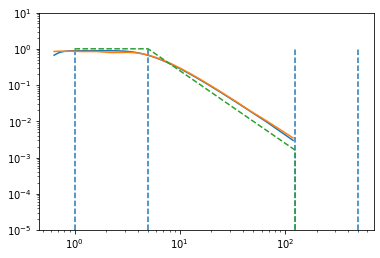

In [1232]:
plt.plot(k_mid, filt_spec_myfilt, '-')
#plt.plot(k_mid, filt_spec_tophat, '-')
plt.plot(k_mid, filt_spec_gradtophat, '-')

plt.plot(k, Ek, '--')



plt.vlines([k_break, k_small, k_large, 2*np.pi/8/dx], 1e-5, 1, linestyle='--')


plt.xscale('log')
plt.yscale('log')

#plt.ylim([min(Ek)*0.5, max(Ek)*1.5])
plt.ylim([1e-5,10])

- Notice that using only top hat gives lot wiggles. This is because lot of filters with top hat look the same to the filter due to the discreteness. 
- With graded top hat there are small scale wiggles, this might also be a resolution issue with the edges. 